In [1]:
import llm
import glob
import base64
import hashlib
import chromadb
from rich import console

c:\Users\prath\anaconda3\envs\ransh\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [3]:
model = llm.get_embedding_model("clip")
c = console.Console()

In [4]:
images = glob.glob("animals/*.png")
images += glob.glob("animals/*.jpg")

In [5]:
embeddings = []
for image in images:
  with open(image, "rb") as image_file:
    embedding = model.embed(image_file.read())
    embeddings.append({
      "embedding": embedding,
      "filePath": image,
      "id": base64.b64encode(hashlib.sha256(image.encode()).digest()).decode()
    })

c:\Users\prath\anaconda3\envs\ransh\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [8]:
chroma_client = chromadb.PersistentClient(path="images.chromadb")
collection = chroma_client.create_collection(name="images")
collection.add(
    embeddings=[e["embedding"] for e in embeddings],
    metadatas=[{k: e[k] for k in ["filePath"]} for e in embeddings],
    ids=[e["id"] for e in embeddings],
)

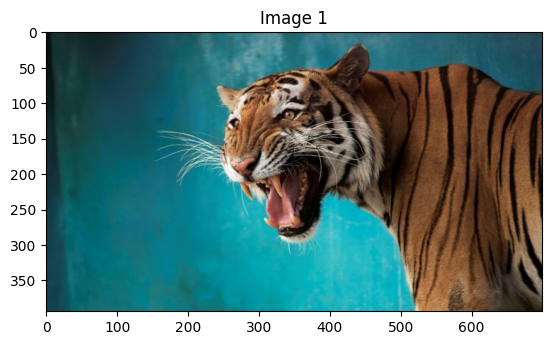

Euclidean distance for Image 1: 0.0
------------------------------


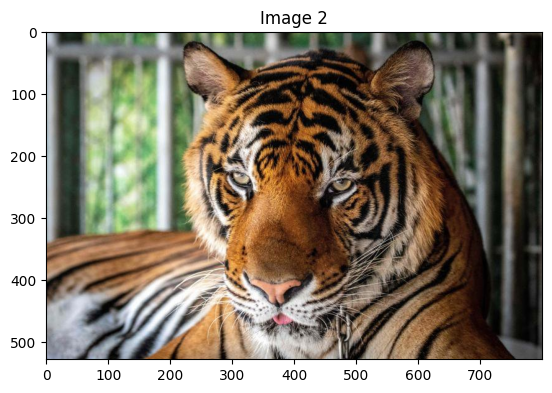

Euclidean distance for Image 2: 21.285934448242188
------------------------------


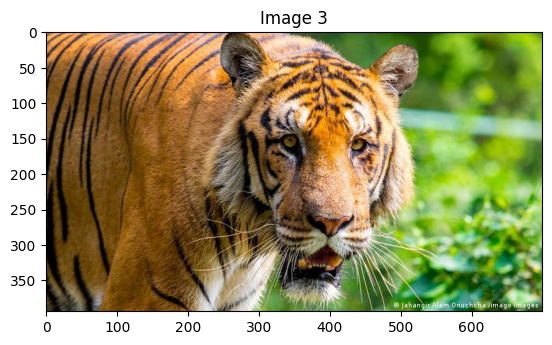

Euclidean distance for Image 3: 31.08125252062406
------------------------------


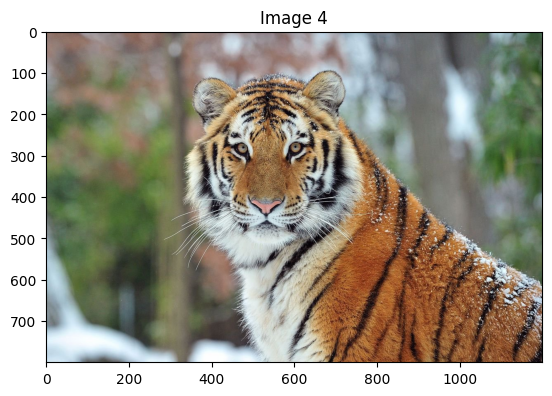

Euclidean distance for Image 4: 32.80136489868164
------------------------------


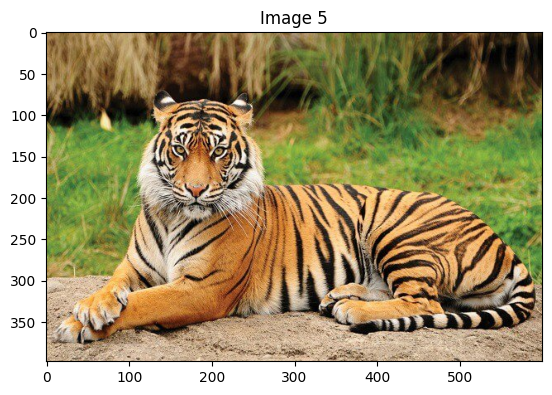

Euclidean distance for Image 5: 37.316524505615234
------------------------------


In [9]:
query_embeddings = model.embed(open("animals/0a5f5db460.jpg", "rb").read())
data = collection.query(
query_embeddings=[query_embeddings],
n_results=5
)

image_paths = data['metadatas'][0]
distances = data['distances'][0]

for i, (image_path, distance) in enumerate(zip(image_paths, distances)):
    # Display image
    img = mpimg.imread(image_path['filePath'])
    plt.imshow(img)
    plt.title(f"Image {i+1}")
    plt.show()

    # Display distance
    print(f"Euclidean distance for Image {i+1}: {distance}")
    print('-' * 30)

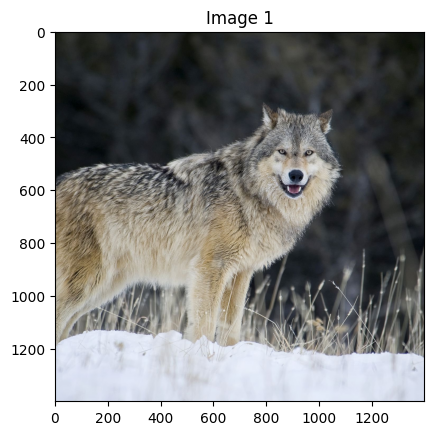

Distance for Image 1: 1.0
------------------------------


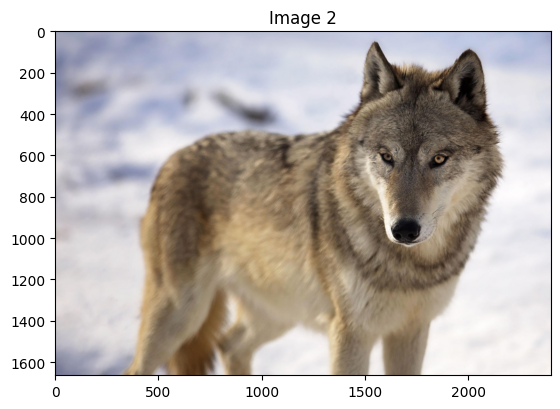

Distance for Image 2: 0.007263959011569521
------------------------------


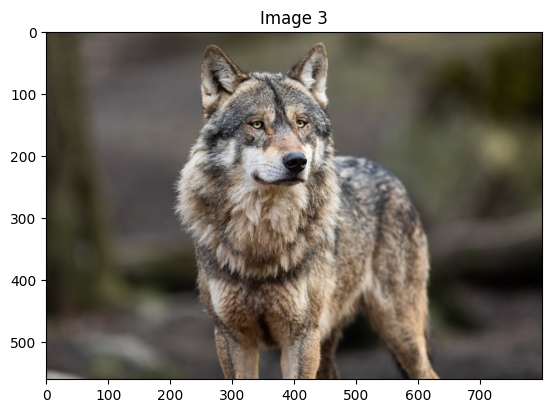

Distance for Image 3: 0.006943253589587053
------------------------------


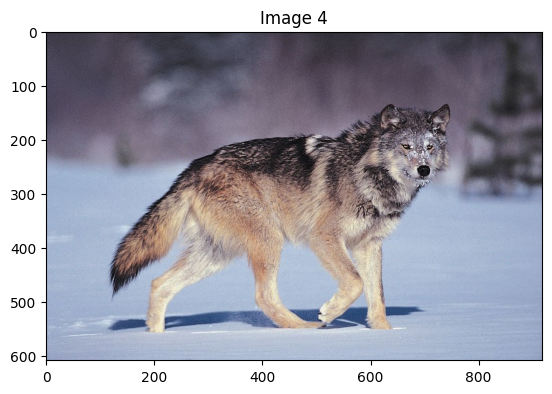

Distance for Image 4: 0.0021904313934145844
------------------------------


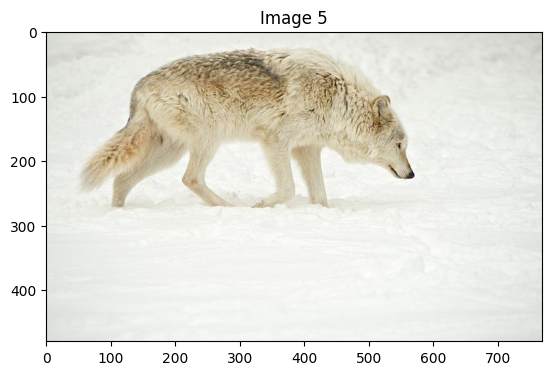

Distance for Image 5: 0.001622945800225348
------------------------------


In [10]:
query_embeddings = model.embed(open("animals/1f73b47867.jpg", "rb").read())
data = collection.query(
query_embeddings=[query_embeddings],
n_results=5
)

image_paths = data['metadatas'][0]
distances = data['distances'][0]
distances = [1 / (1 + dist**2) for dist in distances]

for i, (image_path, distance) in enumerate(zip(image_paths, distances)):
    # Display image
    img = mpimg.imread(image_path['filePath'])
    plt.imshow(img)
    plt.title(f"Image {i+1}")
    plt.show()

    # Display distance
    print(f"Distance for Image {i+1}: {distance}")
    print('-' * 30)

In [11]:
import clip

model, preprocess = clip.load('ViT-B/32', device='cpu')

In [12]:
descriptions = {
    "0a5f5db460": "0aadbd5936",
    "0cf320e7de": "2f855cba6a",
    "4ad3fbedde": "2c3cbf2929",
    "4b038131a9": "4aa7f5ff1d",
    "3c4d9be7a3": "2c7998d692",
    "0f43a8237e": "3b448618eb",
    "0aad5539de": "1f935484c5", 
    "2c9e747589": "05cde5db93"
}

In [13]:
import os
from PIL import Image, ImageTk

original_images = []
original_images1 = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir("animals") if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue
    
    name1=descriptions[name]+".jpg"

    image = Image.open(os.path.join("animals", filename)).convert("RGB")
    image1 = Image.open(os.path.join("animals", name1)).convert("RGB")

    original_images.append(image)
    original_images1.append(image1)
    images.append(preprocess(image))
    texts.append(preprocess(image1))

<Figure size 1600x500 with 0 Axes>

In [14]:
import torch

image_input = torch.tensor(np.stack(images))
text_tokens = torch.tensor(np.stack(texts))
     

with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_image(text_tokens).float()

In [15]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

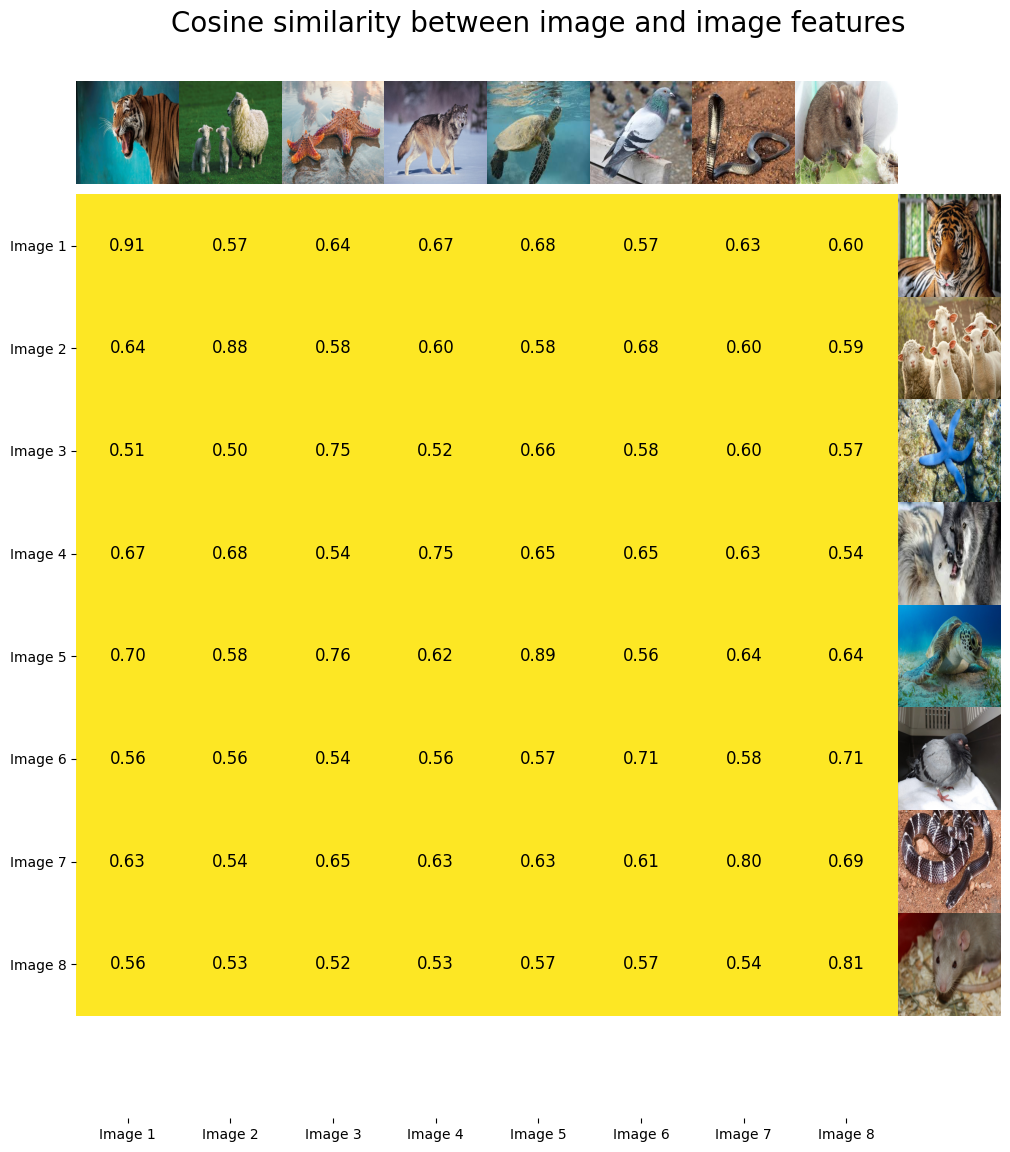

In [16]:
count_x = len(original_images)
count_y = len(original_images1)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count_y), ["Image {}".format(i) for i in range(1, count_y + 1)])
plt.xticks(range(count_x), ["Image {}".format(i) for i in range(1, count_x + 1)])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for j, image1 in enumerate(original_images1):
    plt.imshow(image1, extent=(count_x - 0.5, count_x + 0.5, j - 0.5, j + 0.5), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count_x + 0.5])
plt.ylim([count_y + 0.5, -2])

plt.title("Cosine similarity between image and image features", size=20)
plt.show()
